In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob


In [2]:
files=glob.glob('../archive/*.csv')
files

['../archive/parque_nacional_iguacu.csv',
 '../archive/parque_chapada_dos_veadeiros.csv',
 '../archive/museu_imperial.csv',
 '../archive/mercado-central-fortaleza-ce.csv',
 '../archive/jardim_botanico.csv',
 '../archive/aqua-rio-rj.csv',
 '../archive/mercado-ver-o-peso-pa.csv',
 '../archive/praia-copacabana-rj.csv',
 '../archive/elevador_lacerda.csv',
 '../archive/pelourinho_ba.csv',
 '../archive/museu_arte_sp.csv',
 '../archive/praca-3-poderes-br.csv',
 '../archive/parque_jalapao.csv',
 '../archive/hopi_hari.csv',
 '../archive/beto-carreiro-sc.csv']

In [3]:
#dados será um dicionário com os comentários e as notas de cada usuário
# as chaves do dicionário são os nomes das atrações turísticas

dados={}

for file in files:
    dados[file.split('/')[-1].split('.')[0]]=pd.read_csv(file, delimiter=';')



In [4]:
dados.keys()

dict_keys(['parque_nacional_iguacu', 'parque_chapada_dos_veadeiros', 'museu_imperial', 'mercado-central-fortaleza-ce', 'jardim_botanico', 'aqua-rio-rj', 'mercado-ver-o-peso-pa', 'praia-copacabana-rj', 'elevador_lacerda', 'pelourinho_ba', 'museu_arte_sp', 'praca-3-poderes-br', 'parque_jalapao', 'hopi_hari', 'beto-carreiro-sc'])

In [14]:
# Análise exploratória

In [5]:
def proporcao_notas(dados):
    '''
    Funcao recebe como input um dicionário com o conjunto de dados inicial e retorna um dataframe específico
    para a atração selecionada contendo o número de avaliações com cada nota e a proporção de cada nota 
    '''
    cont=0
    print('Número correpondente a cada atração')
    for i in dados.keys():
        print(str(cont) +'-' +i )
        cont+=1
    
    
    num=None
    while num not in np.arange(1,16):
        try:
            num=input('Selecione a atração (digite o número correpondente a atração desejada ou -1 para sair): ')
            num=int(num)
            if num not in np.arange(1,16):
                raise Exception()
        except:
            if num==-1:
                return None
            print('Entrada Inválida. Digite o número da atração desejada ou -1 para sair')
    nome_atracao=list(dados.keys())[num]
    dados_atracao=dados[nome_atracao]
    notas_atracao=dados_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    print('')
    print('Nome da atração: {}'.format(nome_atracao))
    print('Total de avaliações: {}'.format(notas_atracao['Número_de_Avaliações'].sum()))
    print(notas_atracao)
    return notas_atracao
    

    
                 

In [7]:
teste=proporcao_notas(dados)

Número correpondente a cada atração
0-parque_nacional_iguacu
1-parque_chapada_dos_veadeiros
2-museu_imperial
3-mercado-central-fortaleza-ce
4-jardim_botanico
5-aqua-rio-rj
6-mercado-ver-o-peso-pa
7-praia-copacabana-rj
8-elevador_lacerda
9-pelourinho_ba
10-museu_arte_sp
11-praca-3-poderes-br
12-parque_jalapao
13-hopi_hari
14-beto-carreiro-sc
Entrada Inválida. Digite o número da atração desejada ou -1 para sair

Nome da atração: aqua-rio-rj
Total de avaliações: 4199
      Número_de_Avaliações  Proporção de Avaliações
nota                                               
1.0                    108                 0.025720
2.0                    204                 0.048583
3.0                    633                 0.150750
4.0                   1353                 0.322220
5.0                   1901                 0.452727


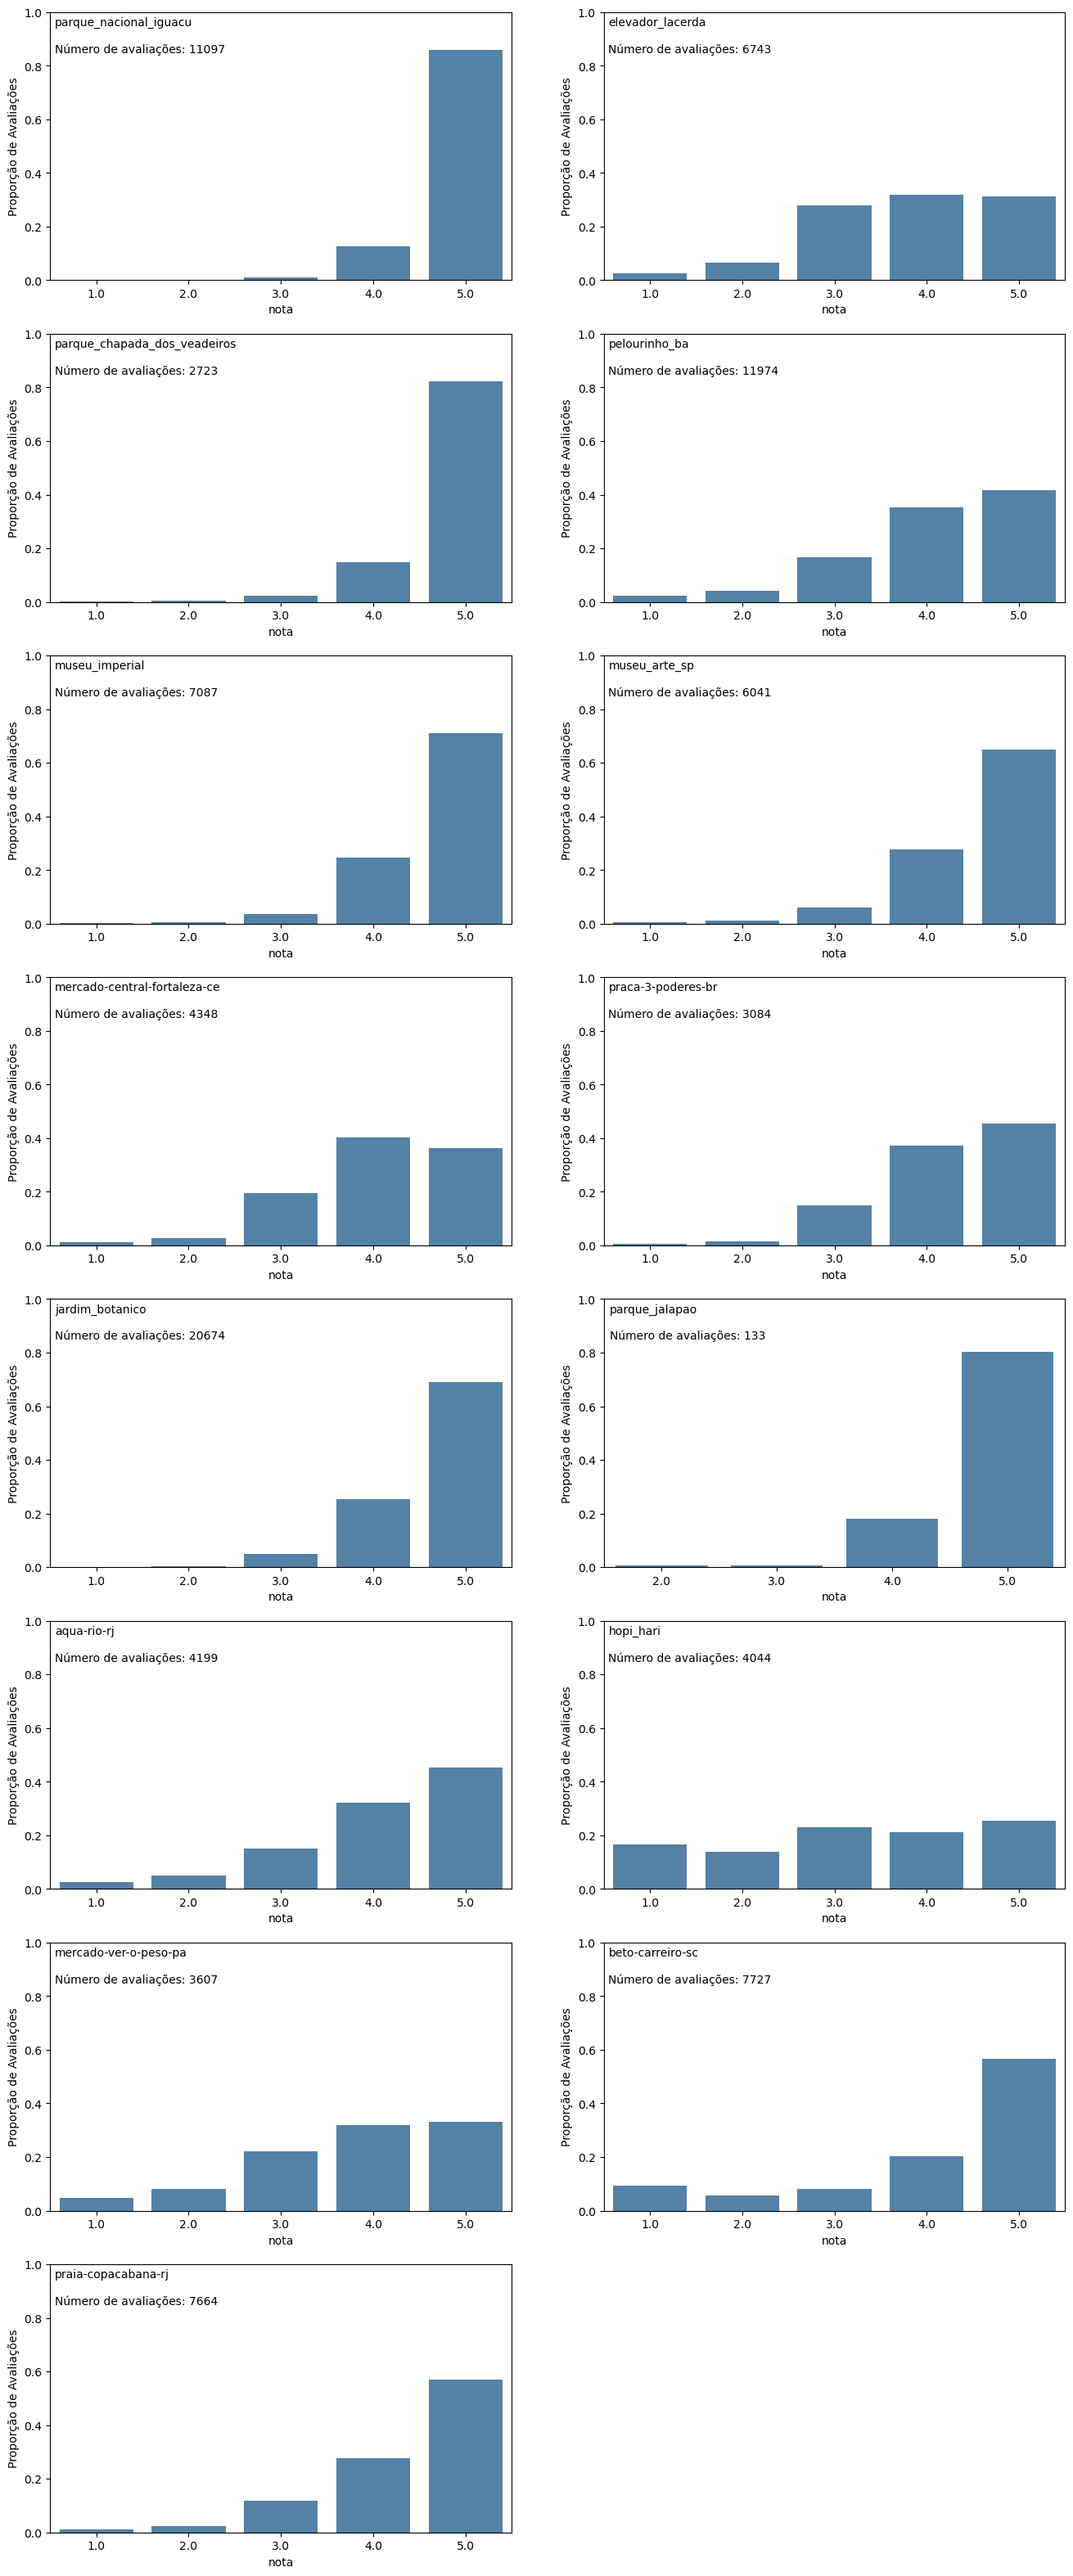

In [53]:
#Plotar graficos com as proporções das avaliações para cada atração
fig,axs=plt.subplots(8,2,figsize=(16,40))
atracoes=list(dados.keys())
row_subplot=0
col_subplot=0
for atracao in atracoes:
    notas_atracao=dados[atracao]
    notas_atracao=notas_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    notas_atracao.reset_index(inplace=True)
    ax=sns.barplot(notas_atracao,x='nota',y='Proporção de Avaliações',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, atracao)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao['Número_de_Avaliações'].sum()))
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])


In [61]:
resumo_avaliações={'Atracao':[],
                   'Número de Avaliações':[],
                   'Total de Avaliações Positivas':[],
                   'Total de Avaliações Positivas':[],
                   'Total de Avaliações Positivas':[],
                   'Total de Avaliações Positivas':[]}